# 1. Model diagnostics

This notebook runs a series of diagnostic tests for the sea level regression model with storm surge. The following tests on the results and model assumptions are implemented:
- Normality
- Outliers
- Serial correlation
- Autocorrelation
- Homoscedasticity

-----
In Dutch:
In dit notebook zijn diverse diagnostische testen en controles op de resultaten van de zeespiegelmonitor geïmplementeerd.

De volgende statistische toetsen en controles zijn hieronder uitgewerkt.
-	Toets op normaliteit: Jarque-Bera test en Q-Q plot van residuen (quantile-quantile plot, ook wel normal probability plot genoemd). (1)
-	Controle op uitbijters (outlier detection): standaard residuenplot en een plot van de residuen tegen de leverage (een functie van de regressoren) en grafieken van de predictie-intervallen van het regressiemodel en de waarnemingen liggen. (1)
-	Toets op seriecorrelatie: Breusch-Godfrey test. (2)
-	Toets op autocorrelatie: Autocorrelatiefunctie (ACF) en Durbin-Watson test. (2)
-	Toets op homo-/heteroskedasticiteit (is de variantie van de residuen gelijk over de gehele sample, is de spreiding in de residuen als functie van de variabelen constant?):  Breusch-Pagan test, plot residuals vs. fitted values en plot sqrt(standardized residuals) vs. fitted values. (1) en (3) 

(1) In R levert plot(LinMod) vier grafieken op. Linksboven staat de plot residuals vs. fitted values, linksonder de plot sqrt(standardized residuals) vs. fitted values. Rechtsboven staat de Q-Q plot van de residuen. Rechtsonder staat een plot van residuals vs. leverage, waarbij leverage een functie is van de regressoren. Zie ook https://data.library.virginia.edu/diagnostic-plots/. 

(2) De toetsen op seriecorrelatie en autocorrelatie hebben veel met elkaar te maken. Zie http://www.eviews.com/help/helpintro.html#page/content/timeser-Testing_for_Serial_Correlation.html

(3) Zie https://datascienceplus.com/how-to-detect-heteroscedasticity-and-rectify-it/ en https://www.theanalysisfactor.com/linear-models-r-diagnosing-regression-model/

N.B. Jarque-Bera en Durbin-Watson zitten al in de standaard model summary.

In [1]:
# Standard Python packages
import io

# Python packages that need to be installed using pip or anaconda:
# For computations
import pandas
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import bokeh.palettes
import bokeh.plotting
from bokeh.models import HoverTool

# Initialize modules for the jupyter notebook format
from nbformat import current
%matplotlib inline
bokeh.io.output_notebook()

from IPython.display import display
import shutil

import statsmodels.graphics.regressionplots as plots

# Disable pandas warnings
pandas.options.mode.chained_assignment = None

C:\Users\nicolai.HKV\AppData\Local\Continuum\anaconda3\lib\site-packages\nbformat\current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


Loading BokehJS ...

In [2]:
def execute_notebook(nbfile):
    """Function to run other notebook in this notebook"""
    with io.open(nbfile,encoding="utf8") as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)

In [3]:
# Load notebook with basic io functionality (wind, PSMSL) and standard linear model
execute_notebook('../satellite/get-data.ipynb')

In [4]:
# laad eerste het model met de summary
station_names = [
    'Vlissingen', 
    'Hoek van Holland', 
    'Den Helder', 
    'Delfzijl', 
    'Harlingen', 
    'IJmuiden'
]

# Locatie wind data is 50 km uit kust vanuit IJmuiden
rlr_data = get_station_data(dataset_name='rlr_annual', coastline_code=150, names=station_names, include_wind=False)

rlr_annual 20 rlr
rlr_annual 22 rlr
rlr_annual 23 rlr
rlr_annual 24 rlr
rlr_annual 25 rlr
rlr_annual 32 rlr


In [5]:
stations = [20, 22, 23, 24, 25, 32]

grouped = pandas.concat(rlr_data.loc[stations, 'data'].tolist())[['year', 'height']].groupby(['year'])
mean_df = grouped.mean().reset_index()
# filter out non-trusted part (before NAP)
mean_df = mean_df[mean_df['year'] >= 1890]

station_names = [st.capitalize() for st in rlr_data.loc[stations, 'name'].tolist()]

print(f'The sea water level data of the following stations are analyzed: {", ".join(station_names)}')

The sea water level data of the following stations are analyzed: Vlissingen, Hoek van holland, Den helder, Delfzijl, Harlingen, Ijmuiden


In [6]:
mean_df.index = mean_df['year']
display(mean_df.head(), mean_df.tail())

,year,height
year,,
1890,1890,-194.666667
1891,1891,-179.000000
1892,1892,-166.500000
1893,1893,-142.166667
1894,1894,-141.833333


,year,height
year,,
2013,2013,25.666667
2014,2014,66.666667
2015,2015,92.500000
2016,2016,77.000000
2017,2017,112.166667


In [7]:
# Sea level data range
print(f'Sea level data for the period')
print(min(mean_df.year.values), max(mean_df.year.values))

Sea level data for the period
1890 2017


In [8]:
import getpass
username = getpass.getuser()
print(username)

if username == 'rongen': 
    surgepath = 'D:/Documents/2695.50 Zeespiegelstijging 2018/Data/'
elif username == 'nicolai':
    surgepath = 'D:/Users/' + username + '/Documents/2695.50 Zeespiegelstijging 2018/Data/'
    print(surgepath)
else:
#    print('enter path where surge is stored using forward slashes')
#    surgepath = input()
#    print(surgepath)
    print('path not valid')

#print(surgepath + 'surge.pkl')   

#'D:\Users\Nicolai\Documents\2695.50 Zeespiegelstijging 2018\Data'

# Add surge
# Load surge and convert from meters to mm
#surge = pandas.read_pickle(surgepath + 'surge.pkl') * 1000
#print(surge.head(5), surge.tail(5))

nicolai
D:/Users/nicolai/Documents/2695.50 Zeespiegelstijging 2018/Data/


In [9]:
# Add surge
# Load surge and convert from meters to mm

# Guus
# surge = pandas.read_pickle('D:/Documents/2695.50 Zeespiegelstijging 2018/Data/surge.pkl') * 1000 

# Robin
surgepath = 'D:/Users/Nicolai/Documents/2695.50 Zeespiegelstijging 2018/Data/'
surge = pandas.read_pickle(surgepath + 'surge.pkl') * 1000

print(surge.head(5), surge.tail(5))

# Calculate average over given stations, per year
# if monthly averages are needed, groupby "surge.index.month"
average = surge[station_names].groupby(surge.index.year).mean().mean(axis=1)
# Construct dataframe and add to mean_df
surge_per_year = pandas.DataFrame(data=[average.mean()] * len(mean_df), index=mean_df['year'], columns=['surge'])
surge_per_year.loc[average.index, 'surge'] = average.values
surge_per_year.index.name = 'year'
if 'surge' not in mean_df.columns:
    mean_df = mean_df.merge(surge_per_year.reset_index(), on='year')

# Create a corrected dataframe by subtracting the surge
mean_df_corrected = mean_df.copy()
mean_df_corrected['height'] -= mean_df_corrected['surge']   


                     Vlissingen  Hoek van holland  Den helder   Delfzijl  \
1979-01-01 00:00:00    0.000000          0.000000    0.000000   0.000000   
1979-01-01 00:10:00   -0.249468          0.590325    0.806396  -3.677294   
1979-01-01 00:20:00   -0.890010          1.760389    3.596331 -11.441492   
1979-01-01 00:30:00   -1.303061          2.307753    7.541155 -16.544901   
1979-01-01 00:40:00   -1.140522          1.127529   10.611323 -14.176514   

                     Harlingen  Ijmuiden  
1979-01-01 00:00:00   0.000000  0.000000  
1979-01-01 00:10:00  -2.944402 -0.753033  
1979-01-01 00:20:00  -5.254048 -2.288197  
1979-01-01 00:30:00  -4.505036 -3.556560  
1979-01-01 00:40:00  -5.693127 -4.844942                        Vlissingen  Hoek van holland  Den helder   Delfzijl  \
2014-12-31 23:10:00 -177.668601       -153.670296  -95.220782  15.352673   
2014-12-31 23:20:00 -181.090802       -151.775345  -74.545339  10.494649   
2014-12-31 23:30:00 -181.896344       -149.892956  -74.13

C:\Users\nicolai.HKV\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: 'year' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


In [10]:
# storm surge data range

print(f'Storm surge data for the period')
print(min(surge.index.year), '-', max(surge.index.year))

Storm surge data for the period
1979 - 2014


Run the linear regression model with storm surge.

In [11]:
def linear_model_with_surge(df):
    """
    Return the fit from the linear model on the given dataset df.
    Wind and season can be enabled and disabled
    """
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613),
        df['surge']# * (df['year'] >= 1979)    
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V', 'Surge']
        
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop')
    fit = model.fit()
    #fit = model.fit(cov_type='HC0')
    return fit, names

In [12]:
linear_fit_with_surge, names = linear_model_with_surge(mean_df)
table = linear_fit_with_surge.summary(
    yname='Sea-surface height', 
    xname=names, 
    title='Linear model (1890 - current), with surge (1979-current)'
)
display(table)

<class 'statsmodels.iolib.summary.Summary'>
"""
           Linear model (1890 - current), with surge (1979-current)           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     255.2
Date:                Thu, 06 Sep 2018   Prob (F-statistic):           1.54e-58
Time:                        15:32:34   Log-Likelihood:                -593.96
No. Observations:                 128   AIC:                             1198.
Df Residuals:                     123   BIC:                             1212.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.1142      2.482     -9.313      0.000     -28.027     -18.201
Trend          1.9267      0.062     31.324      0.000       1.805       2.048
Nodal U        4.5272      3.210      1.410      0.161      -1.827      10.881
Nodal V      -10.8684      3.212     -3.384      0.001     -17.226      -4.511
Surge          0.9018      0.144      6.259      0.000       0.617       1.187
==============================================================================
Omnibus:                        3.042   Durbin-Watson:                   1.505
Prob(Omnibus):                  0.219   Jarque-Bera (JB):                2.517
Skew:                          -0.258   Prob(JB):                        0.284
Kurtosis:                       3.454   Cond. No.                         57.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let us also fit the model from the first year storm surge data are available.

In [13]:
linear_fit_with_surge_1979, names = linear_model_with_surge(mean_df[mean_df.year >= 1979])
table_1979 = linear_fit_with_surge_1979.summary(
    yname='Sea-surface height', 
    xname=names, 
    title='Linear model (1979-current), with surge (1979-current)'
)
display(table_1979)

<class 'statsmodels.iolib.summary.Summary'>
"""
            Linear model (1979-current), with surge (1979-current)            
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     66.95
Date:                Thu, 06 Sep 2018   Prob (F-statistic):           1.22e-15
Time:                        15:32:34   Log-Likelihood:                -156.03
No. Observations:                  39   AIC:                             322.1
Df Residuals:                      34   BIC:                             330.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -37.8291      6.433     -5.881      0.000     -50.902     -24.756
Trend          2.5335      0.215     11.784      0.000       2.097       2.970
Nodal U       -5.7997      3.151     -1.841      0.074     -12.202       0.603
Nodal V      -13.1298      3.523     -3.727      0.001     -20.289      -5.970
Surge          0.9271      0.080     11.524      0.000       0.764       1.091
==============================================================================
Omnibus:                        0.889   Durbin-Watson:                   1.176
Prob(Omnibus):                  0.641   Jarque-Bera (JB):                0.820
Skew:                           0.086   Prob(JB):                        0.664
Kurtosis:                       2.311   Cond. No.                         88.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Both regression models have been fitted using OLS. The standard erros are nonrobust, i.e., we have not accounted (yet) for possible heteroskedasticity, autocorrelation or serial correlation. We shall now formally check the model assumptions. 

Before we do that we consider the output table of the full model (1979-current): 

Jarque-Bera test: null hypothesis (normal distributed residuals) cannot be rejected at the 5% significance level.

Durbin-Watson test statistic: the null hypothesis is that the errors are serially uncorrelated against the alternative that they follow a first order autoregressive process. The test statistic is about 1.5 and the critical values at 5% significance are: (low) 1.64595, (high) 1.77568. This implies that we should reject the null hypothesis. 
- data set: 1890-2016 (T = 127)
- number of parameters: K = 5 including the constant (df_model:= K-1 = 4)

PM
The null hypothesis is that the errors are serially uncorrelated against the alternative that they follow a first order autoregressive process. The Durbin-Watson test statistic equals 1.541. The critical values at 5% significance are: (low) 1.64595, (high) 1.77568. This implies that we should reject the null hypothesis.

Fitting the model to data from 1979 onwards gives an even lower DW test statistic, implying rejection of the null-hypothesis.

## Normality
Let us first check if the (fitted) residuals are normally distributed. We do several visual checks and consider statistical tests.

### Statistical test
The Jarque-Bera test statistic is 2.517 with p-value 0.284. Hence, the null hypothesis of normality cannot be rejected at a significance level of 5%. [To do: including numbers from table in text.]

### Q-Q-plot of the residuals
Next we create the quantile-quantile plot of the residuals. That is, we plot the theoretical quantiles (normal distribution) against the data quantiles (ranks).

The first plot relates to the residuals of the full model, the second plot to the residuals from 1979 from the full model and the third plot relates to the residuals of the model fitted to the data from 1979 onwards.

The Q-Q-plots do not show large irregularities in the residuals. Higher quantiles (0.7-0.9) are somewhat overrepresented and the quantiles 0.3-0.5 are somewhat underrepresented (first plot, full model). 

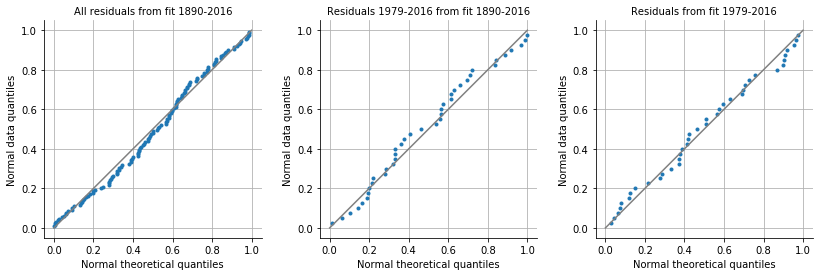

In [14]:
fig, axs = plt.subplots(figsize=(14, 4), ncols=3)
from scipy.stats import norm

for startyear, ax, fit, title in zip(
    [1890, 1979, 1979],
    axs,
    [linear_fit_with_surge, linear_fit_with_surge, linear_fit_with_surge_1979],
    ['All residuals from fit 1890-2016', 'Residuals 1979-2016 from fit 1890-2016', 'Residuals from fit 1979-2016']
):
    
    years = fit.model.exog[:, 1] + 1970
    index = (years >= startyear)
#     print(index)

    
    ax.set_aspect(1.0)

    # Calculate the exceedance probabilities given a normal distribution
    residuals = fit.resid.values[index]
    cprob = norm.cdf(
        sorted(residuals),
        loc=residuals.mean(),
        scale=residuals.std()
    )
    # Calculate the data quantiles: rank / (n + 1)
#     print(fit.resid.rank().values)
#     print(np.argsort(residuals))
    ranks = (np.arange(len(residuals)) + 1) / (len(residuals) + 1)

    # Scatter
    ax.plot(cprob, ranks, marker='.', ls='')
    # Plot the 1-1 line
    ax.plot([0, 1], [0, 1], ls='-', color='0.5')

    # Layout
    ax.grid()
    ax.set_ylabel('Normal data quantiles')
    ax.set_xlabel('Normal theoretical quantiles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_title(title, fontsize=10)

C:\Users\nicolai.HKV\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  app.launch_new_instance()


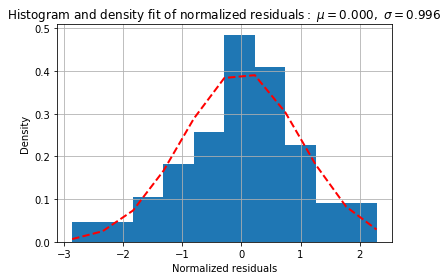

In [15]:
import matplotlib.mlab as mlab

norm_resid = (linear_fit_with_surge.resid - linear_fit_with_surge.resid.mean()) / linear_fit_with_surge.resid.std() 

n, bins, patches = plt.hist(norm_resid, density = True)
plt.ylabel('Density')
plt.xlabel('Normalized residuals');

# best fit of data
(mu, sigma) = norm.fit(norm_resid)

# the histogram of the data
#n, bins, patches = plt.hist(datos, 60, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

plt.title(r'$\mathrm{Histogram\ and\ density\ fit\ of\ normalized\ residuals:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)
plt.show()

The distribution of the normalized residuals of the full model is close to a normal distribution.

## Outliers
Outliers can have an impact on the parameter estimates and the fitted residuals. Below we first plot the fitted sea levels including confidence and prediction intervals. Next we plot the residuals against time and against leverage.

In [16]:
# Code om betrouwbaarheidsintervallen en predictie-intervallen te maken

# Confidence intervals paramemeters using t-distribution
# print(linear_fit_with_surge.conf_int(alpha=0.05, cols=None)) 
## linear_fit_with_surge.conf_int_el # using empirical likelihood

from statsmodels.stats.outliers_influence import summary_table, OLSInfluence
lfws = linear_fit_with_surge
st, data, ss2 = summary_table(lfws, alpha=0.05)
#print(lfws.model.nobs)
#print(lfws.model.exog_names)

fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T # confidence interval
predict_ci_low, predict_ci_upp = data[:,6:8].T # prediction interval

# check we got the right things
#print(fittedvalues)
#print(np.max(np.abs(lfws.fittedvalues - fittedvalues)))
#print(np.max(np.abs(iv_l - predict_ci_low))) #iv_l and iv_u are lower and upper values prediction interval from another method
#print(np.max(np.abs(iv_u - predict_ci_upp))) #

In [17]:
# plot the model with storm surge and add confidence and prediction intervals
# grafieken van de predictie-intervallen van het regressiemodel en de waarnemingen.
for startyear in [1890, 1979]:

    fig = bokeh.plotting.figure(x_range=(startyear, 2020), plot_width=900, plot_height=400)

    fig.circle(
        mean_df.year,
        mean_df.height,
        line_width=1,
        legend='Annual sea level (data)',
        color='black',
        alpha=0.5
    )

    fig.line(
        linear_fit_with_surge.model.exog[:, 1] + 1970, 
        linear_fit_with_surge.predict(), 
        line_width=3, 
        legend='Current sea level (linear model with surge)', 
        color='black',
        alpha=0.5
    )
    
    for values, label, color, lw in zip([predict_ci_low, predict_ci_upp, predict_mean_ci_low, predict_mean_ci_upp],
                             ['95% prediction interval', '', '95% confidence interval', ''],
                             ['blue', 'blue', 'red', 'red'],
                             [2, 2, 1, 1]):
        fig.line(
            linear_fit_with_surge.model.exog[:, 1] + 1970, 
            values, 
            line_width=lw, 
            legend=label, 
            color=color,
            alpha=0.5
        )

    fig.legend.location = "bottom_right"
    fig.yaxis.axis_label = 'water level [mm] above NAP'
    fig.xaxis.axis_label = 'year'
    #fig.legend.click_policy = "hide"

    bokeh.io.show(fig)

Only a few observations are outside the prediction intervals. It is remarkable to see so many observations in the confidence interval. The sea level in year 1996 is comparatively low. The fit is good though.

In [18]:
# Controle op uitbijters (outlier detection): standaard residuenplot 

# residual plot
fig = bokeh.plotting.figure(x_range=(1890, 2020), plot_width=900, plot_height=400)
fig.circle(
    mean_df.year,
    linear_fit_with_surge.resid,
    line_width=1,
    legend='Residuals',
    color='black',
    alpha=0.5
)

fig.legend.location = "top_left"
fig.yaxis.axis_label = 'water level [mm] above NAP'
fig.xaxis.axis_label = 'year'
#fig.legend.click_policy = "hide"

bokeh.io.show(fig)

print('The graph shows a sort of cyclical pattern in the residuals implying autocorrelation.')

print('From 2005 onwards the residuals increase. The residuals between 2014-2017 are relatively large, but in the early 1960s the residuals have been large as well.') 

print('The lack of storm surge data from 2015 onwards is likely to contribute to the high values in 2015-2017.')

The graph shows a sort of cyclical pattern in the residuals implying autocorrelation.
From 2005 onwards the residuals increase. The residuals between 2014-2017 are relatively large, but in the early 1960s the residuals have been large as well.
The lack of storm surge data from 2015 onwards is likely to contribute to the high values in 2015-2017.


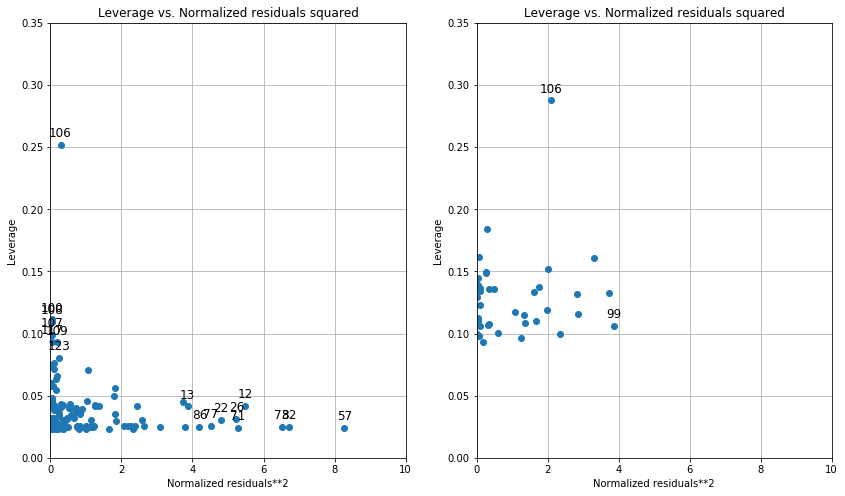

In [19]:
# influence = linear_fit_with_surge_1979.get_influence()
# frame = influence.summary_frame()
# display(frame.sort_values(by='hat_diag', ascending=False).head())

# print(linear_fit_with_surge.model.exog[106, 1] + 1970)
# fig, ax = plt.subplots()

# ax.scatter(frame['hat_diag'], frame['standard_resid'], s=20, alpha=0.5)
# ax.set_ylabel('Standardized residuals')
# ax.set_xlabel('Leverage');

fig, axs = plt.subplots(figsize=(14, 8), ncols=2)
plots.plot_leverage_resid2(linear_fit_with_surge, ax=axs[0]);
plots.plot_leverage_resid2(linear_fit_with_surge_1979, ax=axs[1]);

for ax in axs:
    ax.set_ylim(0.0, 0.35)
    ax.set_xlim(0.0, 10.0)
    ax.grid()

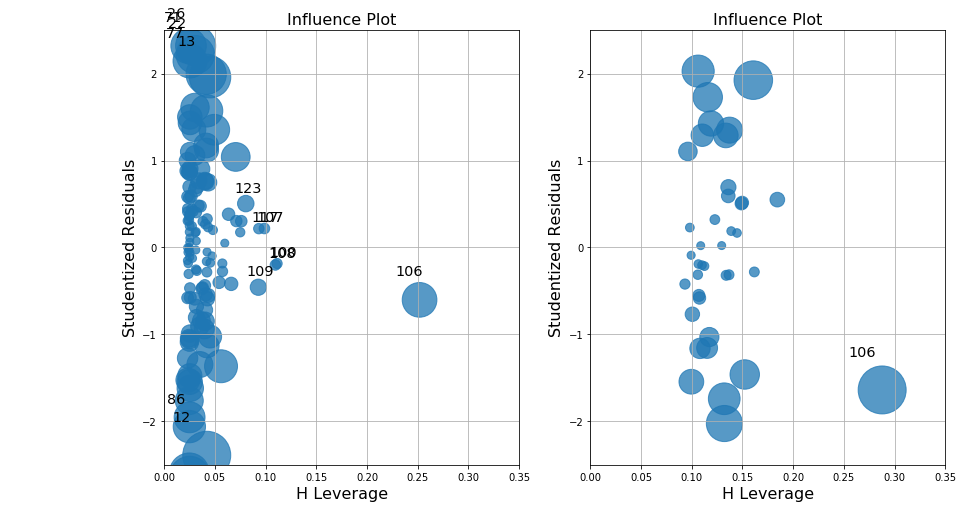

In [20]:
fig, axs = plt.subplots(figsize=(14, 8), ncols=2)
plots.influence_plot(linear_fit_with_surge, ax=axs[0]);
plots.influence_plot(linear_fit_with_surge_1979, ax=axs[1]);

for ax in axs:
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlim(0.0, 0.35)
    ax.grid()

The above plots show that the year 1996 has the highest leverage. The influence is relatively high, but some other years with the same leverage have the same influence. 

### Serial correlation: Breusch-Godfrey test
The null hypothesis of the Breusch-Godfrey test is no serial correlation.

#### References
Breusch, T. S. (1978). "Testing for Autocorrelation in Dynamic Linear Models". Australian Economic Papers. 17: 334–355. doi:10.1111/j.1467-8454.1978.tb00635.x.

Godfrey, L. G. (1978). "Testing Against General Autoregressive and Moving Average Error Models when the Regressors Include Lagged Dependent Variables". Econometrica. 46: 1293–1301. JSTOR 1913829.

In [21]:
import pandas as pd
import statsmodels

fig = bokeh.plotting.figure(x_range=(1890, 2020), y_range=(-80, 80), plot_width=900, plot_height=400)

resid_df = pd.DataFrame(
    data=linear_fit_with_surge.resid.values,
    index=mean_df_corrected.year,
    columns=['residuals']
)
resid_df['5 year rolling average'] = resid_df.rolling(window=5, center=True).mean()

fig.line(resid_df.index.values, resid_df['residuals'].values,
         line_width=2, color='blue', alpha=0.5, legend='Residuals')
fig.line(resid_df.index.values, resid_df['5 year rolling average'].values,
         line_width=2, color='red', alpha=0.5, legend='Moving average (5 years)')


fig.legend.location = "bottom_right"
fig.yaxis.axis_label = 'water level [mm] above NAP'
fig.xaxis.axis_label = 'year'

bokeh.io.show(fig)

# statsmodels.stats.diagnostic.acorr_breusch_godfrey?
bg = statsmodels.stats.diagnostic.acorr_breusch_godfrey(linear_fit_with_surge)

print("""
Lagrange multiplier test statistic: {:.3f}
P-value for Lagrange multiplier test: {:.3f}
Fstatistic for F test: {:.3f}
P-value for F test: {:.3f}
""".format(*bg))


Lagrange multiplier test statistic: 22.614
P-value for Lagrange multiplier test: 0.031
Fstatistic for F test: 1.985
P-value for F test: 0.032



The null hypothesis "No serial correlation" is rejected at the 5% significance level. This is in line with the outcome of the Durbin-Watson test (on autocorrelation). This conclusion means that the covariance matrix and hence the standard errors might be too small.

One way of dealing with autocorrelation is estimating the standard errors in a more robust way (White). 

Another way of dealing with autocorrelation is using an AR(p) model. Therefore, we shall first check the autocorrelation function to see what the lag is in the dependent variable.

Remark. In case of autocorrelation and heteroscedasticity one can apply the HAC estimator to retrieve robust standard errors (statsmodels.stats.sandwich_covariance.cov_hac; Newey-West covariance matrix estimator). In the last section of this notebook we  test on homoscedasticity and implement robust standard errors.

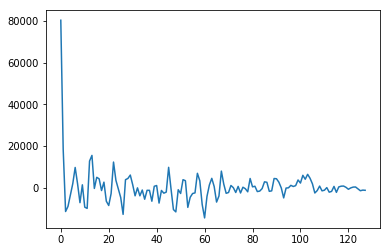

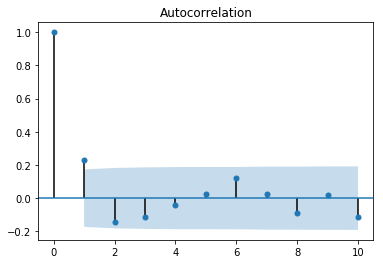

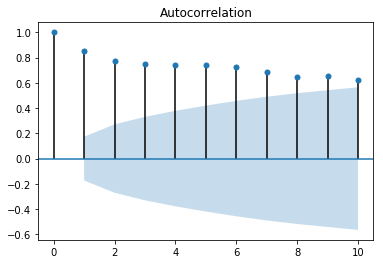

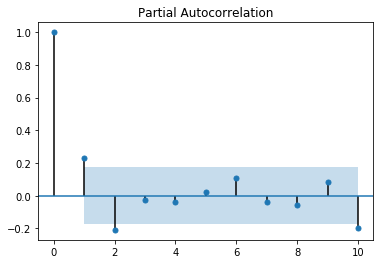

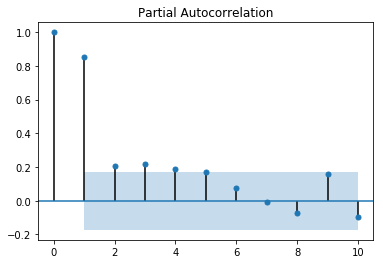

In [22]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[np.int(result.size/2):]

plt.plot(autocorr(resid_df['residuals'].values))

#from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Remark: 
# ACF from residuals and mean sea level
plot_acf(resid_df['residuals'].values, lags=10)
pyplot.show()

plot_acf(mean_df.height.values, lags=10)
pyplot.show()

# PACF from residuals and mean sea level
plot_pacf(resid_df['residuals'].values, lags=10)
pyplot.show()

plot_pacf(mean_df.height.values, lags=10)
pyplot.show()

The ACF and partial ACF of the residuals and the sea levels show autoregression with lag 1. This is in line with the outcomes of the statistical tests on autocorrelation and serial correlation. We could estimate an AR(1) model to deal with the autocorrelation. Neglecting autocorrelation could lead to incorrect standard errors. Another option is 'correcting' the standard errors for autocorrelation (and other types misspecification - heteroscedasticity).

### Homoscedastic or heteroskedastic residuals: 
#### Breusch-Pagan test
The null hypothesis of the Breusch-Pagan and White test is homoscedastic residuals. The White test is a special case of the B-P test.

Breusch, T. S.; Pagan, A. R. (1979). "A Simple Test for Heteroskedasticity and Random Coefficient Variation". Econometrica. 47 (5): 1287–1294. doi:10.2307/1911963. JSTOR 1911963. MR 0545960.

Cook, R. D.; Weisberg, S. (1983). "Diagnostics for Heteroskedasticity in Regression". Biometrika. 70 (1): 1–10. doi:10.1093/biomet/70.1.1.

White, H. (1980). "A Heteroskedasticity-Consistent Covariance Matrix Estimator and a Direct Test for Heteroskedasticity". Econometrica. 48 (4): 817–838. JSTOR 1912934. MR 0575027.

First we plot the residuals against the main independent variables: nodal cycle and surge. Subsequently we perform the B-P test and the White test.

In [23]:
def predict_nodal(C, D, year):
    """
    C : float
        Coefficient from the sin-component
    D : float
        Coefficient from the cos-component
    """
    
    # Recreate the nodal cycle from the sinus and cosinus components.
    # It does not matter that we use the time-independent parameters.
    phi = np.arctan(D / C)
    A = (C**2 + D**2) ** 0.5
    Tn = 18.613
    
    return A * np.sin((2 * np.pi * year) / Tn + phi)


    All residuals from fit 1890-2017:
    ---------------------------------------
    Lagrange multiplier test statistic: 39.389
    P-value for Lagrange multiplier test: 0.000
    Fstatistic for F test: 18.522
    P-value for F test: 0.000
    

    Residuals 1979-2017 from fit 1890-2017:
    ---------------------------------------
    Lagrange multiplier test statistic: 17.032
    P-value for Lagrange multiplier test: 0.000
    Fstatistic for F test: 9.304
    P-value for F test: 0.000
    

    All residuals from fit 1979-2017:
    ---------------------------------------
    Lagrange multiplier test statistic: 17.075
    P-value for Lagrange multiplier test: 0.000
    Fstatistic for F test: 9.345
    P-value for F test: 0.000
    


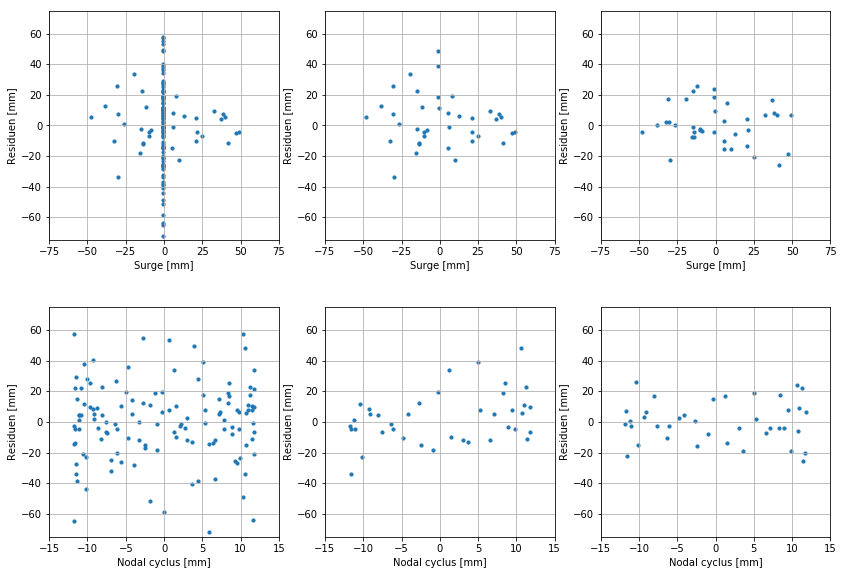

In [24]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(14, 10))

for i, (yearmin, fit, title) in enumerate(zip(
    [1890, 1979, 1979],
    [linear_fit_with_surge, linear_fit_with_surge, linear_fit_with_surge_1979],
    ['All residuals from fit 1890-2017', 'Residuals 1979-2017 from fit 1890-2017', 'All residuals from fit 1979-2017']
)):

    # Select years
    indices = mean_df['year'] >= yearmin

    # Get surge and residuals for fit and years
    surge = mean_df.loc[indices, 'surge'].values
    residuals = fit.resid.tail(len(surge)).values
    
    # Plot surge
    ax = axs[0, i]
    ax.scatter(surge, residuals, s=10)
    ax.set_xlabel('Surge [mm]')
    ax.set_xlim(-75, 75)
    ax.set_aspect(1.0)
    
    # Format
    for ax in axs[:, i]:
        ax.grid()
        ax.set_ylabel('Residuen [mm]')
        ax.set_ylim(-75, 75)    
    
    # Nodal
    C, D = linear_fit_with_surge.params.x2, linear_fit_with_surge.params.x3
    nodal_pred = predict_nodal(C, D, mean_df.loc[indices, 'year'])
    ax = axs[1, i]
    ax.scatter(nodal_pred, residuals, s=10)
    ax.set_xlabel('Nodal cyclus [mm]')
    ax.set_xlim(-15, 15)
    ax.set_aspect(0.2)

    # Breusch-Pagan test
    bp = statsmodels.stats.diagnostic.het_breuschpagan(residuals, mean_df.loc[indices].values)

    print("""
    {}:
    ---------------------------------------
    Lagrange multiplier test statistic: {:.3f}
    P-value for Lagrange multiplier test: {:.3f}
    Fstatistic for F test: {:.3f}
    P-value for F test: {:.3f}
    """.format(title, *bp))
    
    # https://www.statsmodels.org/dev/stats.html   


The plots show that the spread in the residuals somewhat depends on the value of the nodal cycle and the surge residuals.  Therefore it is not suprising that the null hypothesis of the Breusch-Pagan test is rejected at the 5% significance level.

In [25]:
# Remark. The White test and Goldfeld-Quandt test are not yet applicable in Python's statsmodels module. 

    # White test
    wt = statsmodels.stats.diagnostic.het_white(residuals, mean_df.loc[indices].values)

    print("""
    {}:
    ---------------------------------------
    Lagrange multiplier test statistic: {:.3f}
    P-value for Lagrange multiplier test: {:.3f}
    Fstatistic for F test: {:.3f}
    P-value for F test: {:.3f}
    """.format(title, *wt))
    
    # Goldfeld-Quandt test
    gq = statsmodels.stats.diagnostic.het_goldfeldquandt(residuals, mean_df.loc[indices].values)

    print("""
    {}:
    ---------------------------------------
    Lagrange multiplier test statistic: {:.3f}
    P-value for Lagrange multiplier test: {:.3f}
    Fstatistic for F test: {:.3f}
    P-value for F test: {:.3f}
    """.format(title, *gq))

#### Residuals vs. fitted values
The same conclusions are drawn after plotting the residuals against the fitted sea water levels. The spread is higher for the lower fitted sea levels. This is because the lower fitted values relate to the begin period and in that period (until 1979) the surge does not explain any variance. Adding the surge to the model from the year 1979 onwards yields lower variation in the residuals. Still, the residuals show more variation for the lower and higher fitted values.

This leads to the final conclusion that the model describes the data well and that most model assumptions are reasonable. There is some evidence of serial corrrelation and heteroscedasticity in the residuals. Therefore the model requires robust estimation of standard errors. This can be easily incorporated with the option "cov_type='HC0' or "cov_type='hac'" in the function "model.fit()". For example, "fit = model.fit(cov_type='HC0')". The two covariance estimators are applied below.

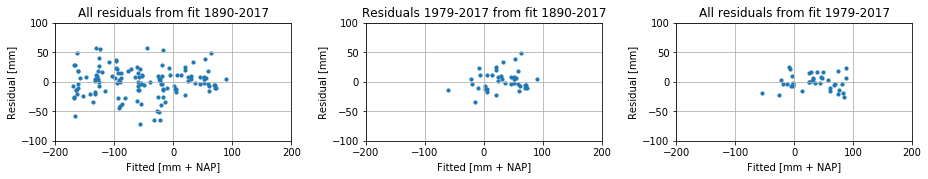

In [26]:
fig, axs = plt.subplots(ncols=3, figsize=(13, 6))

for i, (yearmin, fit, title) in enumerate(zip(
    [1890, 1979, 1979],
    [linear_fit_with_surge, linear_fit_with_surge, linear_fit_with_surge_1979],
    ['All residuals from fit 1890-2017', 'Residuals 1979-2017 from fit 1890-2017', 'All residuals from fit 1979-2017']
)):

    # Select years
    indices = mean_df['year'] >= yearmin

    # Get surge and residuals for fit and years
    predicted = fit.fittedvalues[indices]
    residuals = fit.resid.tail(len(predicted)).values
    
    # Plot surge
    ax = axs.ravel()[i]
    ax.scatter(predicted, residuals, s=10)
    ax.set_xlabel('Fitted [mm + NAP]')
    ax.set_xlim(-200, 200)
    ax.set_aspect(1.0)
    
    ax.grid()
    ax.set_ylabel('Residual [mm]')
    ax.set_ylim(-100, 100)   
    
    ax.set_title(title)
    
plt.tight_layout()

In [27]:
def linear_model_with_surge_robust_hc0(df):
    """
    Return the fit from the linear model on the given dataset df.
    Wind and season can be enabled and disabled
    """
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613),
        df['surge']# * (df['year'] >= 1979)    
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V', 'Surge']
        
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop')
    #fit = model.fit()
    fit = model.fit(cov_type='HC0')
    return fit, names

In [28]:
display(table) # summary table regression results with 'uncorrected' standard errors

linear_fit_with_surge, names = linear_model_with_surge_robust_hc0(mean_df)
table_hc0 = linear_fit_with_surge.summary(
    yname='Sea-surface height', 
    xname=names, 
    title='Linear model (1890 - current), with surge (1979-current)'
)
display(table_hc0)

<class 'statsmodels.iolib.summary.Summary'>
"""
           Linear model (1890 - current), with surge (1979-current)           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     255.2
Date:                Thu, 06 Sep 2018   Prob (F-statistic):           1.54e-58
Time:                        15:32:34   Log-Likelihood:                -593.96
No. Observations:                 128   AIC:                             1198.
Df Residuals:                     123   BIC:                             1212.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.1142      2.482     -9.313      0.000     -28.027     -18.201
Trend          1.9267      0.062     31.324      0.000       1.805       2.048
Nodal U        4.5272      3.210      1.410      0.161      -1.827      10.881
Nodal V      -10.8684      3.212     -3.384      0.001     -17.226      -4.511
Surge          0.9018      0.144      6.259      0.000       0.617       1.187
==============================================================================
Omnibus:                        3.042   Durbin-Watson:                   1.505
Prob(Omnibus):                  0.219   Jarque-Bera (JB):                2.517
Skew:                          -0.258   Prob(JB):                        0.284
Kurtosis:                       3.454   Cond. No.                         57.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
           Linear model (1890 - current), with surge (1979-current)           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     410.7
Date:                Thu, 06 Sep 2018   Prob (F-statistic):           4.05e-70
Time:                        15:32:39   Log-Likelihood:                -593.96
No. Observations:                 128   AIC:                             1198.
Df Residuals:                     123   BIC:                             1212.
Df Model:                           4                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.1142      2.235    -10.341      0.000     -27.495     -18.733
Trend          1.9267      0.055     34.898      0.000       1.819       2.035
Nodal U        4.5272      3.113      1.454      0.146      -1.574      10.629
Nodal V      -10.8684      3.193     -3.403      0.001     -17.127      -4.610
Surge          0.9018      0.069     13.071      0.000       0.767       1.037
==============================================================================
Omnibus:                        3.042   Durbin-Watson:                   1.505
Prob(Omnibus):                  0.219   Jarque-Bera (JB):                2.517
Skew:                          -0.258   Prob(JB):                        0.284
Kurtosis:                       3.454   Cond. No.                         57.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [29]:
def linear_model_with_surge_robust_hac(df):
    """
    Return the fit from the linear model on the given dataset df.
    Wind and season can be enabled and disabled
    """
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613),
        df['surge']# * (df['year'] >= 1979)    
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V', 'Surge']
        
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop')
    fit = model.fit(cov_type='HAC', cov_kwds={'maxlags':1}) # 1 lag (see ACF)
    return fit, names

In [30]:
linear_fit_with_surge, names = linear_model_with_surge_robust_hac(mean_df)
table_hac = linear_fit_with_surge.summary(
    yname='Sea-surface height', 
    xname=names, 
    title='Linear model (1890 - current), with surge (1979-current)'
)
display(table_hac)

<class 'statsmodels.iolib.summary.Summary'>
"""
           Linear model (1890 - current), with surge (1979-current)           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     365.8
Date:                Thu, 06 Sep 2018   Prob (F-statistic):           2.92e-67
Time:                        15:32:40   Log-Likelihood:                -593.96
No. Observations:                 128   AIC:                             1198.
Df Residuals:                     123   BIC:                             1212.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.1142      2.572     -8.985      0.000     -28.156     -18.072
Trend          1.9267      0.062     31.320      0.000       1.806       2.047
Nodal U        4.5272      3.377      1.341      0.180      -2.091      11.146
Nodal V      -10.8684      3.544     -3.067      0.002     -17.815      -3.922
Surge          0.9018      0.071     12.750      0.000       0.763       1.040
==============================================================================
Omnibus:                        3.042   Durbin-Watson:                   1.505
Prob(Omnibus):                  0.219   Jarque-Bera (JB):                2.517
Skew:                          -0.258   Prob(JB):                        0.284
Kurtosis:                       3.454   Cond. No.                         57.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""